# Package

In [1]:
# pip install statsmodels


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import acf
import missingno as msno

# Load data

In [3]:
def load_data():
    df = pd.read_csv('../data/kzhan176/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [4]:
df = load_data()
df.head()

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [5]:
# GOAL 预测当前这笔存款（item_amt）最终是否会被return（退票）
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   masked_dep_acct_num       17765 non-null  int64  
 1   masked_bank_num           17765 non-null  int64  
 2   masked_account_type       17765 non-null  int64  
 3   masked_id                 17765 non-null  int64  
 4   masked_product_code       17765 non-null  int64  
 5   bucket_days_since_open    17738 non-null  object 
 6   number_of_owners          17765 non-null  int64  
 7   total_deposit_amount      17765 non-null  float64
 8   item_amt                  17765 non-null  float64
 9   deposit_dt                17765 non-null  object 
 10  channel                   17765 non-null  object 
 11  relationship_balance      17765 non-null  int64  
 12  oao_flg                   17765 non-null  object 
 13  onus_ind                  17765 non-null  object 
 14  treasu

# First pipeline - raw data and added features

A pipeline using the combination of raw data and newly added features, evaluated with XGBoost

- Use raw data + new features with only minimal cleaning (no scaling, no clipping, no missing value imputation) and let XGBoost handle the data directly.

In [6]:
df.query('relationship_balance == 0').head(4)

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
2421,5485,0,0,6149,1,0-1000,1,281.00,281.00,2024-08-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8
3566,8034,0,0,9252,1,0-1000,0,537.00,537.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15,3
7054,15306,0,1,18674,2,0-1000,2,11117.79,11117.79,2024-08-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8
7244,15700,0,0,19191,1,0-1000,1,12000.00,12000.00,2024-08-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8


In [7]:
def xgboost_pipeline(df):
    """
    XGBoost Feature Engineering Pipeline

    This pipeline performs minimal cleaning and targeted feature engineering
    to prepare the dataset for XGBoost modeling. Specifically, it:

    - Drops irrelevant or identifier columns that are not useful for prediction
    - Extracts temporal features (quarter, week) from the deposit date
    - Creates ratio-based and volatility-based transaction features
    - Creates frequency-based features from historical transaction dates
    - Creates behavioral flags based on deposit amount anomalies
    - Processes bucketed and binary categorical features into numeric form
    - Preserves missing values (np.nan) without imputation
    - Does not perform feature scaling or one-hot encoding
    - Leaves outlier values as-is without clipping

    The resulting dataset is fully numeric, with missing values retained, and ready for XGBoost models.
    """

    # --------------- Drop columns --------------- 
    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
    ]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- process deposit_dt columns --------------- 
    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
    df['fe_deposit_quarter'] = df['deposit_dt'].dt.quarter
    df['fe_deposit_week'] = df['deposit_dt'].dt.isocalendar().week
    df = df.drop(columns=['deposit_dt'])


    # --------------- process item_amt, total_deposit_amount, relationship_balance columns --------------- 
    ## Ratio of current deposit item amount to total deposit amount, large single deposits are potentially unusual 如果一笔交易占今天总交易很大一部分会不会是诈骗
    df['fe_amt_ratio_to_total'] = df['item_amt'] / (df['total_deposit_amount'] + 1)
    ## Ratio of current deposit item amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果一笔交易占用户总余额很大一部分会不会是诈骗
    df['fe_amt_ratio_to_balance'] = df['item_amt'] / (df['relationship_balance'] + 1)
    ## Ratio of total deposit amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果今天的总交易占用户总余额很大一部分会不会是诈骗
    df['fe_total_amt_ratio_to_balance'] = df['total_deposit_amount'] / (df['relationship_balance'] + 1)
    ## Difference between current deposit amount and previous transaction amount, abnormal fluctuations 如果这笔交易比上一笔变化很多会不会是诈骗
    df['fe_amt_change_from_prev'] = df['item_amt'] - df['prevtran1']
    ## Flag indicating whether the current deposit item is 1.5x larger than the past 30-day maximum deposit, Is it significantly higher than the largest deposit in the last 30 days 如果一笔交易是这一个月的最大交易会不会是诈骗
    df['fe_high_amt_flag'] = (df['item_amt'] > (df['max_deposit_amount30d'] * 1.5)).astype(int)
    ## Ratio of maximum single deposit amount in past 30 days to the total deposit amount 
    df['fe_max30d_ratio_total'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1)

    # --------------- process rdis columns --------------- 
    ## fill NA as 0 to rdis
    df['rdis'] = df['rdis'].fillna(0)
    df['fe_rdis_flag'] = (df['rdis'] > 0).astype(int)

    # --------------- process prevtrandate columns --------------- 
    ## process prevtrandate to capture short-term transaction frequency.
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    # Create transaction count features
    ## Number of transactions within 1 day
    df['fe_num_trans_in_1d'] = (df[prevtrandate_cols] <= 1).sum(axis=1)
    ## Number of transactions within 5 days
    df['fe_num_trans_in_5d'] = (df[prevtrandate_cols] <= 5).sum(axis=1)
    ## Number of transactions within 10 days
    df['fe_num_trans_in_10d'] = (df[prevtrandate_cols] <= 10).sum(axis=1)
    ## Average days between previous transactions
    df['fe_avg_prevtrandate'] = df[prevtrandate_cols].mean(axis=1)
    ## Standard deviation of days between previous transactions
    df['fe_std_prevtrandate'] = df[prevtrandate_cols].std(axis=1)
    ## Rolling mean of the most recent 3 and 5 previous transaction days
    df['fe_rolling_mean_prevtrandate_3'] = df[prevtrandate_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtrandate_5'] = df[prevtrandate_cols[:5]].mean(axis=1)
    ## Rolling standard deviation of the most recent 3 and 5 previous transaction days
    df['fe_rolling_std_prevtrandate_3'] = df[prevtrandate_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtrandate_5'] = df[prevtrandate_cols[:5]].std(axis=1)


    # ------------ process prevtran columns ------------
    # volatility of item_amt compared to historical transaction amounts
    ## Mean of previous 10 deposits  ps If there is all NaN, the result of std is NaN!
    df['fe_avg_prevtran_amt'] = df[prevtran_cols].mean(axis=1)
    ## Standard deviation of previous 10 deposits ps If there is only 1 valid number or all NaN, the result of std is NaN!
    df['fe_std_prevtran_amt'] = df[prevtran_cols].std(axis=1)
    ## Maximum amount among previous 10 deposits ps If there is all NaN, the result of std is NaN!
    df['fe_max_prevtran_amt'] = df[prevtran_cols].max(axis=1)
    ## Current deposit amount compared to historical average 
    df['fe_amt_current_vs_avg'] = df['item_amt'] / (df['fe_avg_prevtran_amt'] + 1)
    ## Current deposit amount compared to historical maximum 
    df['fe_amt_current_vs_max'] = df['item_amt'] / (df['fe_max_prevtran_amt'] + 1)
    # Rolling part to capture short-term behavioral trends from the latest 3 or 5 transactions.
    # Rolling mean of the most recent 3 and 5 previous transactions ps If there is all NaN, the result of std is NaN!
    df['fe_rolling_mean_prevtran_3'] = df[prevtran_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtran_5'] = df[prevtran_cols[:5]].mean(axis=1)
    # Rolling standard deviation of the most recent 3 and 5 previous transactions ps if If there is only 1 valid number or all NaN, the result is NaN!
    df['fe_rolling_std_prevtran_3'] = df[prevtran_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtran_5'] = df[prevtran_cols[:5]].std(axis=1)
    ## Create a feature indicating whether the current deposit is the first known deposit
    df['fe_is_first_deposit'] = df[prevtran_cols].isna().all(axis=1).astype(int)


    # --------------- Label Encoding ---------------
    ##  --------------- process mapping_bucket_days columns to approximate days(med) --------------- 
    mapping_bucket_days = {
        '0-1000': 500,
        '1000-2000': 1500,
        '2000-5000': 3500,
        '5000+': 6000
    }
    df['fe_days_since_open'] = df['bucket_days_since_open'].map(mapping_bucket_days)
    df = df.drop(columns=['bucket_days_since_open'])
    ## --------------- process oao_flg columns ---------------
    mapping_oao_flg = {
        'N': 0,
        'Y': 1
    }
    df['fe_oao_flg'] = df['oao_flg'].map(mapping_oao_flg)
    df = df.drop(columns=['oao_flg'])
    ## --------------- process onus_ind columns ---------------
    mapping_onus_ind = {
        'F': 0,
        'T': 1
    }
    df['fe_onus_ind'] = df['onus_ind'].map(mapping_onus_ind)
    df = df.drop(columns=['onus_ind'])
    ## --------------- process treasury_check_ind columns ---------------
    mapping_treasury_check_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_treasury_check_ind'] = df['treasury_check_ind'].map(mapping_treasury_check_ind)
    df = df.drop(columns=['treasury_check_ind'])
    ## --------------- process heloc_ind columns ---------------
    mapping_heloc_ind = {
        'N': 0,
        'Y': 1
    }
    df['fe_heloc_ind'] = df['heloc_ind'].map(mapping_heloc_ind)
    df = df.drop(columns=['heloc_ind'])

    
    df_xgboost = df.copy()

    return df_xgboost


## check

In [8]:
pd.set_option('display.max_columns', None)

df_xgboost = xgboost_pipeline(df)
df_xgboost.head()

,masked_bank_num,masked_account_type,masked_product_code,number_of_owners,total_deposit_amount,item_amt,relationship_balance,rdis,max_deposit_amount30d,total_deposit_item_count,prevtran1,prevtran2,prevtran3,prevtran4,prevtran5,prevtran6,prevtran7,prevtran8,prevtran9,prevtran10,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,return_target,month_num,fe_deposit_quarter,fe_deposit_week,fe_amt_ratio_to_total,fe_amt_ratio_to_balance,fe_total_amt_ratio_to_balance,fe_amt_change_from_prev,fe_high_amt_flag,fe_max30d_ratio_total,fe_rdis_flag,fe_num_trans_in_1d,fe_num_trans_in_5d,fe_num_trans_in_10d,fe_avg_prevtrandate,fe_std_prevtrandate,fe_rolling_mean_prevtrandate_3,fe_rolling_mean_prevtrandate_5,fe_rolling_std_prevtrandate_3,fe_rolling_std_prevtrandate_5,fe_avg_prevtran_amt,fe_std_prevtran_amt,fe_max_prevtran_amt,fe_amt_current_vs_avg,fe_amt_current_vs_max,fe_rolling_mean_prevtran_3,fe_rolling_mean_prevtran_5,fe_rolling_std_prevtran_3,fe_rolling_std_prevtran_5,fe_is_first_deposit,fe_days_since_open,fe_oao_flg,fe_onus_ind,fe_treasury_check_ind,fe_heloc_ind
0,0,0,0,1,517.81,517.81,160872,0.0,994.77,1,452.76,464.01,426.27,497.32,356.26,517.25,475.0,425.62,425.62,548.79,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0,1882.21,4.0,470.5525,535.92,400.77,0,8,3,31,0.998073,0.003219,0.003219,65.05,0,1.917407,0,0,0,2,34.1,17.672640,12.666667,19.6,6.350853,10.502381,458.890000,54.872433,548.79,1.125943,0.941832,447.68,439.324,19.376060,52.970501,0,6000.0,0,0,0,0
1,0,0,1,1,150.00,150.00,485,0.0,60.00,1,200.00,200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.00,1.0,150.0000,150.00,150.00,0,4,2,17,0.993377,0.308642,0.308642,-50.00,1,0.397351,0,0,0,0,68.0,4.242641,68.000000,68.0,4.242641,4.242641,200.000000,0.000000,200.00,0.746269,0.746269,200.00,200.000,0.000000,0.000000,0,500.0,0,0,0,0
2,0,0,0,0,2603.24,2451.00,27059,88.0,0.00,2,152.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,1,12,0.941157,0.090576,0.096203,2298.76,1,0.000000,1,1,1,1,0.0,NaN,0.000000,0.0,NaN,NaN,152.240000,NaN,152.24,15.994518,15.994518,152.24,152.240,NaN,NaN,0,6000.0,0,0,0,0
3,0,0,1,0,770.00,770.00,2107,0.0,7000.00,1,9214.80,1310.72,2200.00,2400.00,2400.00,2400.00,7000.0,NaN,NaN,NaN,87.0,123.0,162.0,172.0,172.0,172.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11,4,48,0.998703,0.365275,0.365275,-8444.80,0,9.079118,0,0,0,0,163.0,51.185936,124.000000,143.2,37.509999,37.345682,3846.502857,3005.035672,9214.80,0.200130,0.083552,4241.84,3505.104,4329.601956,3223.420377,0,6000.0,0,0,0,0
4,0,0,1,2,10776.63,145.00,4916,0.0,5953.38,5,750.00,2000.00,310.00,175.00,500.00,1000.00,3000.0,525.00,268.38,225.00,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,7860.00,1.0,7860.0000,7860.00,7860.00,0,5,2,22,0.013454,0.029490,2.191708,-605.00,0,0.552383,0,0,0,0,18.4,2.065591,16.000000,16.8,0.000000,1.788854,875.338000,923.479933,3000.00,0.165461,0.048317,1020.00,747.000,876.755382,733.004093,0,3500.0,0,0,0,0


In [9]:
object_cols = df_xgboost.select_dtypes(include='object').columns.tolist()

print(f"Object columns: {object_cols}")
print(f"Total number of object columns: {len(object_cols)}")

Object columns: []
Total number of object columns: 0


In [10]:
df_xgboost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   masked_bank_num                 17765 non-null  int64  
 1   masked_account_type             17765 non-null  int64  
 2   masked_product_code             17765 non-null  int64  
 3   number_of_owners                17765 non-null  int64  
 4   total_deposit_amount            17765 non-null  float64
 5   item_amt                        17765 non-null  float64
 6   relationship_balance            17765 non-null  int64  
 7   rdis                            17765 non-null  float64
 8   max_deposit_amount30d           17765 non-null  float64
 9   total_deposit_item_count        17765 non-null  int64  
 10  prevtran1                       13378 non-null  float64
 11  prevtran2                       11152 non-null  float64
 12  prevtran3                       

# Second pipeline
- To ensure clean and reliable input for DecisionTreeClassifier and RandomForestClassifier models (scikit-learn), the feature engineering process is divided into two sequential pipelines:
    - Pipeline 1: Drop & Fill
        - DecisionTreeClassifier and RandomForestClassifier in scikit-learn cannot handle NaN values during training.
        - Missing values must be handled before creating new features to prevent NaN propagation during calculations such as ratios, rolling averages, and volatility measures.
    - Pipeline 2: Feature Creation & Label Encoding




## Drop & fill

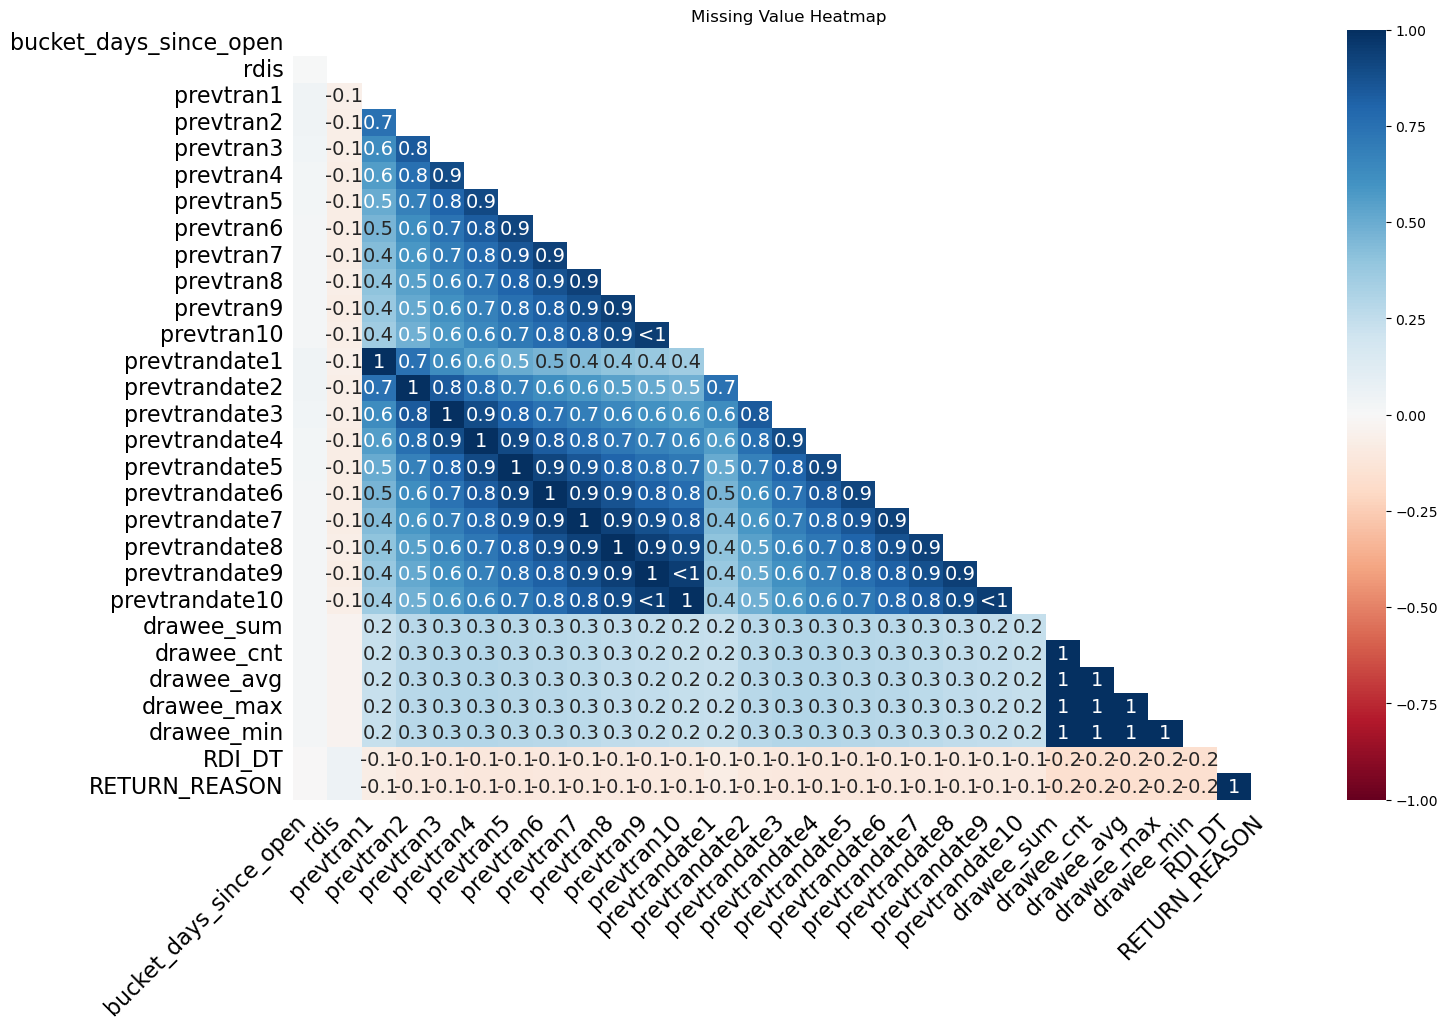

In [11]:
# ➡️ MNAR（Missing Not At Random）
msno.heatmap(df, figsize=(16, 10))
plt.title('Missing Value Heatmap', fontsize=12)
plt.show()

- prevtran1 - prevtran10
    - they are classified as Missing Not At Random (MNAR) because the missingness is directly related to the absence of sufficient historical transaction records for an account. Accounts with fewer prior transactions naturally have missing values for earlier transaction amounts (e.g., if an account has only three prior transactions, prevtran4 to prevtran10 will be missing). Therefore, we impute missing values for prevtran1 to prevtran10 with -1, which:
        - Explicitly signals the absence of historical transaction data.
        - Prevents the model from being misled by a zero value, which could otherwise be interpreted as a valid transaction amount.
        - Allows tree-based models (such as DecisionTreeClassifier and RandomForestClassifier) to naturally split based on the presence or absence of historical transactions without introducing additional noise.

- drawee_sum, drawee_cnt, drawee_avg, drawee_max, and drawee_min
    - For the drawee_sum, drawee_cnt, drawee_avg, drawee_max, and drawee_min features, missing values are imputed with 0.
This is because missingness indicates that no deposits from the payeer occurred in the previous month, and a value of 0 accurately reflects the absence of transactions.

疑问
什么是 transaction

什么是 deposit

In [12]:
def drop_and_fill_pipeline(df):
    """
    Pipeline to drop irrelevant columns and fill missing values.

    Steps:
    - Drop identifier or irrelevant columns
    - Fill missing values for selected features

        bucket_days_since_open → Map + fillna(-1)

        rdis → fillna(0)

        prevtran1-10 → fillna(-1)

        prevtrandate1-10 → fillna(-1)

        drawee_sum/cnt/avg/max/min → fillna(0)
    """

    # --------------- Drop columns --------------- 
    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
    ]
    df_processed = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- Fill columns ---------------
    ## Process bucket_days_since_open
    mapping_bucket_days = {
        '0-1000': 0,
        '1000-2000': 1,
        '2000-5000': 2,
        '5000+': 3,
    }
    df_processed['bucket_days_since_open'] = df_processed['bucket_days_since_open'].map(mapping_bucket_days)
    df_processed['bucket_days_since_open'] = df_processed['bucket_days_since_open'].fillna(-1).astype(int)

    ## Process rdis
    df_processed['rdis'] = df_processed['rdis'].fillna(0)

    ## Process prevtran1 - prevtran10
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    df_processed[prevtran_cols] = df_processed[prevtran_cols].fillna(-1)

    ## Process prevtrandate1 - prevtrandate10
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    df_processed[prevtrandate_cols] = df_processed[prevtrandate_cols].fillna(-1)

    ## Process drawee
    drawee_cols = ['drawee_sum', 'drawee_cnt', 'drawee_avg', 'drawee_max', 'drawee_min']
    df_processed[drawee_cols] = df_processed[drawee_cols].fillna(0)

    return df_processed

In [13]:
pd.set_option('display.max_columns', None)

df_tree_without_missing = drop_and_fill_pipeline(df)
df_tree_without_missing.head()

,masked_bank_num,masked_account_type,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,relationship_balance,oao_flg,onus_ind,treasury_check_ind,heloc_ind,rdis,max_deposit_amount30d,total_deposit_item_count,prevtran1,prevtran2,prevtran3,prevtran4,prevtran5,prevtran6,prevtran7,prevtran8,prevtran9,prevtran10,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,return_target,month_num
0,0,0,0,3,1,517.81,517.81,2024-08-01,160872,N,F,N,N,0.0,994.77,1,452.76,464.01,426.27,497.32,356.26,517.25,475.0,425.62,425.62,548.79,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0,1882.21,4.0,470.5525,535.92,400.77,0,8
1,0,0,1,0,1,150.00,150.00,2024-04-25,485,N,F,N,N,0.0,60.00,1,200.00,200.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,65.0,71.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,150.00,1.0,150.0000,150.00,150.00,0,4
2,0,0,0,3,0,2603.24,2451.00,2024-03-18,27059,N,F,N,N,88.0,0.00,2,152.24,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,3
3,0,0,1,3,0,770.00,770.00,2024-11-29,2107,N,F,N,N,0.0,7000.00,1,9214.80,1310.72,2200.00,2400.00,2400.00,2400.00,7000.0,-1.00,-1.00,-1.00,87.0,123.0,162.0,172.0,172.0,172.0,253.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,11
4,0,0,1,2,2,10776.63,145.00,2024-05-29,4916,N,F,N,N,0.0,5953.38,5,750.00,2000.00,310.00,175.00,500.00,1000.00,3000.0,525.00,268.38,225.00,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,7860.00,1.0,7860.0000,7860.00,7860.00,0,5


In [14]:
missing_count = df_tree_without_missing.isnull().sum()
missing_ratio = df_tree_without_missing.isnull().mean()

missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio': (missing_ratio * 100).round(2) 
}).sort_values(by='Missing Ratio', ascending=False)

missing_summary

,Missing Count,Missing Ratio
masked_bank_num,0,0.0
masked_account_type,0,0.0
masked_product_code,0,0.0
bucket_days_since_open,0,0.0
number_of_owners,0,0.0
total_deposit_amount,0,0.0
item_amt,0,0.0
deposit_dt,0,0.0
relationship_balance,0,0.0
oao_flg,0,0.0


## Feature Creation & Label Encoding

When creating rolling statistics (such as rolling mean or rolling standard deviation), missing values (`NaN`) can arise in two cases:
1. The user truly had transactions, but the transaction amounts were identical, resulting in a standard deviation of 0.
2. The user had no valid previous transactions at all, causing the rolling mean/std calculation to produce `NaN`.

In the previous approach, filling all missing values with 0 mixed these two cases together — the model could not distinguish "stable transactions" from "no transaction history".

Now:


| User | Last 3 Transaction Amounts | Rolling Std | Rolling Std (after fill) | Missing Flag |
|:---|:---|:---|:---|:---|
| A | [100, 100, 100] | 0 | 0 | 0 |
| B | [NaN, NaN, NaN] | NaN | 0 | 1 |

- **User A** had real transactions with no volatility — the standard deviation is 0 and missing flag is 0.
- **User B** had no transactions — the standard deviation is filled to 0 but the missing flag is 1.

This allows the model to clearly understand and separate these two behaviors during training.

In [15]:
def feature_creation_pipeline(df):
    """
    Feature Creation and Label Encoding Pipeline

    This pipeline creates:
    - Ratio-based transaction features
    - Volatility features (mean, std, rolling mean/std)
    - Frequency-based features
    - Behavioral flags
    - Missing flags for rolling features
    """

    df_fe = df.copy()

    # --------------- Process deposit_dt --------------- 
    df_fe['deposit_dt'] = pd.to_datetime(df_fe['deposit_dt'], errors='coerce')
    df_fe['fe_deposit_quarter'] = df_fe['deposit_dt'].dt.quarter
    df_fe['fe_deposit_week'] = df_fe['deposit_dt'].dt.isocalendar().week
    df_fe = df_fe.drop(columns=['deposit_dt'])

    # --------------- Process item_amt / balance-related features --------------- 
    df_fe['fe_amt_ratio_to_total'] = df_fe['item_amt'] / (df_fe['total_deposit_amount'] + 1)
    df_fe['fe_amt_ratio_to_balance'] = df_fe['item_amt'] / (df_fe['relationship_balance'] + 1)
    df_fe['fe_total_amt_ratio_to_balance'] = df_fe['total_deposit_amount'] / (df_fe['relationship_balance'] + 1)
    df_fe['fe_amt_change_from_prev'] = df_fe['item_amt'] - df_fe['prevtran1']
    df_fe['fe_high_amt_flag'] = (df_fe['item_amt'] > (df_fe['max_deposit_amount30d'] * 1.5)).astype(int)
    df_fe['fe_max30d_ratio_total'] = df_fe['max_deposit_amount30d'] / (df_fe['total_deposit_amount'] + 1)

    # --------------- Process rdis --------------- 
    df_fe['fe_rdis_flag'] = (df_fe['rdis'] > 0).astype(int)

    # --------------- Process prevtrandate features --------------- 
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]

    df_fe['fe_num_trans_in_1d'] = (df_fe[prevtrandate_cols] <= 1).sum(axis=1)
    df_fe['fe_num_trans_in_5d'] = (df_fe[prevtrandate_cols] <= 5).sum(axis=1)
    df_fe['fe_num_trans_in_10d'] = (df_fe[prevtrandate_cols] <= 10).sum(axis=1)

    df_fe['fe_avg_prevtrandate'] = df_fe[prevtrandate_cols].replace(-1, pd.NA).mean(axis=1)
    df_fe['fe_std_prevtrandate'] = df_fe[prevtrandate_cols].replace(-1, pd.NA).std(axis=1)

    roll_mean_3 = df_fe[prevtrandate_cols[:3]].replace(-1, pd.NA).mean(axis=1).astype(float)
    roll_mean_5 = df_fe[prevtrandate_cols[:5]].replace(-1, pd.NA).mean(axis=1).astype(float)
    roll_std_3 = df_fe[prevtrandate_cols[:3]].replace(-1, pd.NA).std(axis=1).astype(float)
    roll_std_5 = df_fe[prevtrandate_cols[:5]].replace(-1, pd.NA).std(axis=1).astype(float)

    df_fe['fe_rolling_mean_prevtrandate_3'] = roll_mean_3.fillna(0)
    df_fe['fe_rolling_mean_prevtrandate_5'] = roll_mean_5.fillna(0)
    df_fe['fe_rolling_std_prevtrandate_3'] = roll_std_3.fillna(0)
    df_fe['fe_rolling_std_prevtrandate_5'] = roll_std_5.fillna(0)

    df_fe['fe_rolling_mean_prevtrandate_3_missing_flag'] = roll_mean_3.isna().astype(int)
    df_fe['fe_rolling_mean_prevtrandate_5_missing_flag'] = roll_mean_5.isna().astype(int)
    df_fe['fe_rolling_std_prevtrandate_3_missing_flag'] = roll_std_3.isna().astype(int)
    df_fe['fe_rolling_std_prevtrandate_5_missing_flag'] = roll_std_5.isna().astype(int)

    # --------------- Process prevtran features --------------- 
    df_fe['fe_avg_prevtran_amt'] = df_fe[prevtran_cols].replace(-1, pd.NA).mean(axis=1)
    df_fe['fe_std_prevtran_amt'] = df_fe[prevtran_cols].replace(-1, pd.NA).std(axis=1)
    df_fe['fe_max_prevtran_amt'] = df_fe[prevtran_cols].replace(-1, pd.NA).max(axis=1)
    df_fe['fe_amt_current_vs_avg'] = df_fe['item_amt'] / (df_fe['fe_avg_prevtran_amt'] + 1)
    df_fe['fe_amt_current_vs_max'] = df_fe['item_amt'] / (df_fe['fe_max_prevtran_amt'] + 1)

    roll_mean_3_amt = df_fe[prevtran_cols[:3]].replace(-1, pd.NA).mean(axis=1).astype(float)
    roll_mean_5_amt = df_fe[prevtran_cols[:5]].replace(-1, pd.NA).mean(axis=1).astype(float)
    roll_std_3_amt = df_fe[prevtran_cols[:3]].replace(-1, pd.NA).std(axis=1).astype(float)
    roll_std_5_amt = df_fe[prevtran_cols[:5]].replace(-1, pd.NA).std(axis=1).astype(float)

    df_fe['fe_rolling_mean_prevtran_3'] = roll_mean_3_amt.fillna(0)
    df_fe['fe_rolling_mean_prevtran_5'] = roll_mean_5_amt.fillna(0)
    df_fe['fe_rolling_std_prevtran_3'] = roll_std_3_amt.fillna(0)
    df_fe['fe_rolling_std_prevtran_5'] = roll_std_5_amt.fillna(0)

    df_fe['fe_rolling_mean_prevtran_3_missing_flag'] = roll_mean_3_amt.isna().astype(int)
    df_fe['fe_rolling_mean_prevtran_5_missing_flag'] = roll_mean_5_amt.isna().astype(int)
    df_fe['fe_rolling_std_prevtran_3_missing_flag'] = roll_std_3_amt.isna().astype(int)
    df_fe['fe_rolling_std_prevtran_5_missing_flag'] = roll_std_5_amt.isna().astype(int)

    # --------------- Define critical features ----------------
    critical_features = [
        'fe_avg_prevtrandate',
        'fe_std_prevtrandate',
        'fe_avg_prevtran_amt',
        'fe_std_prevtran_amt',
        'fe_amt_current_vs_max',
        'fe_amt_current_vs_avg',
        'fe_max_prevtran_amt'
    ]


    # --------------- Add missing flags and fillna ---------------
    for feature in critical_features:
        df_fe[f'{feature}_missing_flag'] = df_fe[feature].isna().astype(int)
        df_fe[feature] = df_fe[feature].fillna(0)


    df_fe['fe_is_first_deposit'] = (df_fe[prevtran_cols] == -1).all(axis=1).astype(int)

    # --------------- Label Encoding: remap categorical columns --------------- 
    mapping_bucket_days = {
        0: 500,
        1: 1500,
        2: 3500,
        3: 6000,
        -1: -1  # missing
    }
    df_fe['fe_days_since_open'] = df_fe['bucket_days_since_open'].map(mapping_bucket_days)
    df_fe = df_fe.drop(columns=['bucket_days_since_open'])

    mapping_oao_flg = {'N': 0, 'Y': 1}
    df_fe['fe_oao_flg'] = df_fe['oao_flg'].map(mapping_oao_flg)
    df_fe = df_fe.drop(columns=['oao_flg'])

    mapping_onus_ind = {'F': 0, 'T': 1}
    df_fe['fe_onus_ind'] = df_fe['onus_ind'].map(mapping_onus_ind)
    df_fe = df_fe.drop(columns=['onus_ind'])

    mapping_treasury_check_ind = {'N': 0, 'Y': 1}
    df_fe['fe_treasury_check_ind'] = df_fe['treasury_check_ind'].map(mapping_treasury_check_ind)
    df_fe = df_fe.drop(columns=['treasury_check_ind'])

    mapping_heloc_ind = {'N': 0, 'Y': 1}
    df_fe['fe_heloc_ind'] = df_fe['heloc_ind'].map(mapping_heloc_ind)
    df_fe = df_fe.drop(columns=['heloc_ind'])

    return df_fe


In [16]:
def tree_pipeline(df):
    """
    Run the two preprocessing pipelines sequentially.

    Steps:
    1. Run drop_and_fill_pipeline(df) to get df_fe
    2. Run feature_creation_pipeline(df_fe) to get df_tree

    Returns:
    - df_fe: dataframe after dropping and filling (for simple models or analysis)
    - df_tree: dataframe after feature creation (ready for tree-based models)
    """
    df_fe = drop_and_fill_pipeline(df)
    df_tree = feature_creation_pipeline(df_fe)
    return df_tree


## check

In [17]:
pd.set_option('display.max_columns', None)

df_tree = tree_pipeline(df)
df_tree.head()

/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fe[feature] = df_fe[feature].fillna(0)
/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fe[feature] = df_fe[feature].fillna(0)
/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True

,masked_bank_num,masked_account_type,masked_product_code,number_of_owners,total_deposit_amount,item_amt,relationship_balance,rdis,max_deposit_amount30d,total_deposit_item_count,prevtran1,prevtran2,prevtran3,prevtran4,prevtran5,prevtran6,prevtran7,prevtran8,prevtran9,prevtran10,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,return_target,month_num,fe_deposit_quarter,fe_deposit_week,fe_amt_ratio_to_total,fe_amt_ratio_to_balance,fe_total_amt_ratio_to_balance,fe_amt_change_from_prev,fe_high_amt_flag,fe_max30d_ratio_total,fe_rdis_flag,fe_num_trans_in_1d,fe_num_trans_in_5d,fe_num_trans_in_10d,fe_avg_prevtrandate,fe_std_prevtrandate,fe_rolling_mean_prevtrandate_3,fe_rolling_mean_prevtrandate_5,fe_rolling_std_prevtrandate_3,fe_rolling_std_prevtrandate_5,fe_rolling_mean_prevtrandate_3_missing_flag,fe_rolling_mean_prevtrandate_5_missing_flag,fe_rolling_std_prevtrandate_3_missing_flag,fe_rolling_std_prevtrandate_5_missing_flag,fe_avg_prevtran_amt,fe_std_prevtran_amt,fe_max_prevtran_amt,fe_amt_current_vs_avg,fe_amt_current_vs_max,fe_rolling_mean_prevtran_3,fe_rolling_mean_prevtran_5,fe_rolling_std_prevtran_3,fe_rolling_std_prevtran_5,fe_rolling_mean_prevtran_3_missing_flag,fe_rolling_mean_prevtran_5_missing_flag,fe_rolling_std_prevtran_3_missing_flag,fe_rolling_std_prevtran_5_missing_flag,fe_avg_prevtrandate_missing_flag,fe_std_prevtrandate_missing_flag,fe_avg_prevtran_amt_missing_flag,fe_std_prevtran_amt_missing_flag,fe_amt_current_vs_max_missing_flag,fe_amt_current_vs_avg_missing_flag,fe_max_prevtran_amt_missing_flag,fe_is_first_deposit,fe_days_since_open,fe_oao_flg,fe_onus_ind,fe_treasury_check_ind,fe_heloc_ind
0,0,0,0,1,517.81,517.81,160872,0.0,994.77,1,452.76,464.01,426.27,497.32,356.26,517.25,475.0,425.62,425.62,548.79,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0,1882.21,4.0,470.5525,535.92,400.77,0,8,3,31,0.998073,0.003219,0.003219,65.05,0,1.917407,0,0,0,2,34.1,17.672640,12.666667,19.6,6.350853,10.502381,0,0,0,0,458.890000,54.872433,548.79,1.125943,0.941832,447.68,439.324,19.376060,52.970501,0,0,0,0,0,0,0,0,0,0,0,0,6000,0,0,0,0
1,0,0,1,1,150.00,150.00,485,0.0,60.00,1,200.00,200.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,65.0,71.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,150.00,1.0,150.0000,150.00,150.00,0,4,2,17,0.993377,0.308642,0.308642,-50.00,1,0.397351,0,8,8,8,68.0,4.242641,68.000000,68.0,4.242641,4.242641,0,0,0,0,200.000000,0.000000,200.00,0.746269,0.746269,200.00,200.000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,500,0,0,0,0
2,0,0,0,0,2603.24,2451.00,27059,88.0,0.00,2,152.24,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,3,1,12,0.941157,0.090576,0.096203,2298.76,1,0.000000,1,10,10,10,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,0,1,1,152.240000,0.000000,152.24,15.994518,15.994518,152.24,152.240,0.000000,0.000000,0,0,1,1,0,1,0,1,0,0,0,0,6000,0,0,0,0
3,0,0,1,0,770.00,770.00,2107,0.0,7000.00,1,9214.80,1310.72,2200.00,2400.00,2400.00,2400.00,7000.0,-1.00,-1.00,-1.00,87.0,123.0,162.0,172.0,172.0,172.0,253.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,11,4,48,0.998703,0.365275,0.365275,-8444.80,0,9.079118,0,3,3,3,163.0,51.185936,124.000000,143.2,37.509999,37.345682,0,0,0,0,3846.502857,3005.035672,9214.80,0.200130,0.083552,4241.84,3505.104,4329.601956,3223.420377,0,0,0,0,0,0,0,0,0,0,0,0,6000,0,0,0,0
4,0,0,1,2,10776.63,145.00,4916,0.0,5953.38,5,750.00,2000.00,310.00,175.00,500.00,1000.00,3000.0,525.00,268.38,225.00,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,7860.00,1.0,7860.0000,7860.00,7860.00,0,5,2,22,0.013454,0.029490,2.191708,-605.00,0,0.552383,0,0,0,0,18.4,2.065591,16.000000,16.8,0.000000,1.788854,0,0,0,0,875.338000,923.479933,3000.00,0.165461,0.048317,1020.00,747.000,876.755382,733.004093,0,0,0,0,0,0,0,0,0,0,0,0,3500,0,0,0,0


In [18]:
missing_count = df_tree.isnull().sum()
missing_ratio = df_tree.isnull().mean()

missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Ratio': (missing_ratio * 100).round(2) 
}).sort_values(by='Missing Ratio', ascending=False)

missing_summary

,Missing Count,Missing Ratio
masked_bank_num,0,0.0
masked_account_type,0,0.0
masked_product_code,0,0.0
number_of_owners,0,0.0
total_deposit_amount,0,0.0
...,...,...
fe_days_since_open,0,0.0
fe_oao_flg,0,0.0
fe_onus_ind,0,0.0
fe_treasury_check_ind,0,0.0


In [19]:
object_cols = df_tree.select_dtypes(include='object').columns.tolist()

print(f"Object columns: {object_cols}")
print(f"Total number of object columns: {len(object_cols)}")

Object columns: []
Total number of object columns: 0


In [20]:
df_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 85 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   masked_bank_num                              17765 non-null  int64  
 1   masked_account_type                          17765 non-null  int64  
 2   masked_product_code                          17765 non-null  int64  
 3   number_of_owners                             17765 non-null  int64  
 4   total_deposit_amount                         17765 non-null  float64
 5   item_amt                                     17765 non-null  float64
 6   relationship_balance                         17765 non-null  int64  
 7   rdis                                         17765 non-null  float64
 8   max_deposit_amount30d                        17765 non-null  float64
 9   total_deposit_item_count                     17765 non-null  int64  
 10

# Third pipeline - distance based models

In [21]:
df_pipeline3 = load_data()
df_pipeline3 = tree_pipeline(df_pipeline3)
df_pipeline3

/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fe[feature] = df_fe[feature].fillna(0)
/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_fe[feature] = df_fe[feature].fillna(0)
/tmp/ipykernel_2909002/2643334125.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True

,masked_bank_num,masked_account_type,masked_product_code,number_of_owners,total_deposit_amount,item_amt,relationship_balance,rdis,max_deposit_amount30d,total_deposit_item_count,prevtran1,prevtran2,prevtran3,prevtran4,prevtran5,prevtran6,prevtran7,prevtran8,prevtran9,prevtran10,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,return_target,month_num,fe_deposit_quarter,fe_deposit_week,fe_amt_ratio_to_total,fe_amt_ratio_to_balance,fe_total_amt_ratio_to_balance,fe_amt_change_from_prev,fe_high_amt_flag,fe_max30d_ratio_total,fe_rdis_flag,fe_num_trans_in_1d,fe_num_trans_in_5d,fe_num_trans_in_10d,fe_avg_prevtrandate,fe_std_prevtrandate,fe_rolling_mean_prevtrandate_3,fe_rolling_mean_prevtrandate_5,fe_rolling_std_prevtrandate_3,fe_rolling_std_prevtrandate_5,fe_rolling_mean_prevtrandate_3_missing_flag,fe_rolling_mean_prevtrandate_5_missing_flag,fe_rolling_std_prevtrandate_3_missing_flag,fe_rolling_std_prevtrandate_5_missing_flag,fe_avg_prevtran_amt,fe_std_prevtran_amt,fe_max_prevtran_amt,fe_amt_current_vs_avg,fe_amt_current_vs_max,fe_rolling_mean_prevtran_3,fe_rolling_mean_prevtran_5,fe_rolling_std_prevtran_3,fe_rolling_std_prevtran_5,fe_rolling_mean_prevtran_3_missing_flag,fe_rolling_mean_prevtran_5_missing_flag,fe_rolling_std_prevtran_3_missing_flag,fe_rolling_std_prevtran_5_missing_flag,fe_avg_prevtrandate_missing_flag,fe_std_prevtrandate_missing_flag,fe_avg_prevtran_amt_missing_flag,fe_std_prevtran_amt_missing_flag,fe_amt_current_vs_max_missing_flag,fe_amt_current_vs_avg_missing_flag,fe_max_prevtran_amt_missing_flag,fe_is_first_deposit,fe_days_since_open,fe_oao_flg,fe_onus_ind,fe_treasury_check_ind,fe_heloc_ind
0,0,0,0,1,517.81,517.81,160872,0.0,994.77,1,452.76,464.01,426.27,497.32,356.26,517.25,475.0,425.62,425.62,548.79,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0,1882.21,4.0,470.5525,535.92,400.77,0,8,3,31,0.998073,0.003219,0.003219,65.05,0,1.917407,0,0,0,2,34.100000,17.672640,12.666667,19.6,6.350853,10.502381,0,0,0,0,458.890000,54.872433,548.79,1.125943,0.941832,447.680000,439.324,19.376060,52.970501,0,0,0,0,0,0,0,0,0,0,0,0,6000,0,0,0,0
1,0,0,1,1,150.00,150.00,485,0.0,60.00,1,200.00,200.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,65.0,71.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,150.00,1.0,150.0000,150.00,150.00,0,4,2,17,0.993377,0.308642,0.308642,-50.00,1,0.397351,0,8,8,8,68.000000,4.242641,68.000000,68.0,4.242641,4.242641,0,0,0,0,200.000000,0.000000,200.00,0.746269,0.746269,200.000000,200.000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,500,0,0,0,0
2,0,0,0,0,2603.24,2451.00,27059,88.0,0.00,2,152.24,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0,-1.00,-1.00,-1.00,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,3,1,12,0.941157,0.090576,0.096203,2298.76,1,0.000000,1,10,10,10,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0,0,1,1,152.240000,0.000000,152.24,15.994518,15.994518,152.240000,152.240,0.000000,0.000000,0,0,1,1,0,1,0,1,0,0,0,0,6000,0,0,0,0
3,0,0,1,0,770.00,770.00,2107,0.0,7000.00,1,9214.80,1310.72,2200.00,2400.00,2400.00,2400.00,7000.0,-1.00,-1.00,-1.00,87.0,123.0,162.0,172.0,172.0,172.0,253.0,-1.0,-1.0,-1.0,0.00,0.0,0.0000,0.00,0.00,0,11,4,48,0.998703,0.365275,0.365275,-8444.80,0,9.079118,0,3,3,3,163.000000,51.185936,124.000000,143.2,37.509999,37.345682,0,0,0,0,3846.502857,3005.035672,9214.80,0.200130,0.083552,4241.840000,3505.104,4329.601956,3223.420377,0,0,0,0,0,0,0,0,0,0,0,0,6000,0,0,0,0
4,0,0,1,2,10776.63,145.00,4916,0.0,5953.38,5,750.00,2000.00,310.00,175.00,500.00,1000.00,3000.0,525.00,268.38,225.00,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,7860.00,1.0,7860.0000,7860.00,7860.00,0,5,2,22,0.013454,0.029490,2.191708,-605.00,0,0.552383,0,0,0,0,18.400000,2.065591,16.000000,16.8,0.000000,1.788854,0,0,0,0,875.338000,923.479933,3000.00,0.165461,0.048317,1020.000000,747.000,876.755382,733.004093,0,0,0,0,0,0,0,0,0,0,0,0,3500,0,0,0,0
...,...,...,...,

In [30]:
def normalization(df):
    
    ret_df = df.copy()
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    ret_df[prevtran_cols] = ret_df[prevtran_cols].replace(-1, 0)
    
    # relationship_balance replace placeholder -99999999 with 0
    ret_df["relationship_balance"] = ret_df["relationship_balance"].replace(-99999999, 0)

    # log transformation: columns that have positive values with highly skewed distribution
    log_transform_columns = ["total_deposit_amount", "item_amt", "max_deposit_amount30d", "total_deposit_item_count"] \
        + ["drawee_sum", "drawee_cnt", "drawee_avg", "drawee_max", "drawee_min", "fe_amt_ratio_to_balance"]
    log_transform_columns += prevtran_cols
    ret_df[log_transform_columns] = ret_df[log_transform_columns].apply(np.log1p)

    # signed log transformation: columns that have negative values with highly skewed distribution
    signed_log_transform_columns = ["relationship_balance"]
    for col in signed_log_transform_columns:
        ret_df[col] = np.sign(ret_df[col]) * np.log1p(np.abs(ret_df[col]))
    
    # robust scalar
    robust_scalar_columns = ["rdis", "fe_amt_ratio_to_total", ""] + log_transform_columns + prevtrandate_cols
    robust_scaler = RobustScaler()

    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]

    robust_scalar_features = ['total_deposit_amount', 'item_amt'] + keep_prevtran_cols + \
                        ['prevtran_mean', 'prevtran_std', 'prevtran_sum', 'prevtran_diff0', 'prevtran_ratio0'] + \
                        ['prevtran_diff1', 'prevtran_ratio1', 'acf_lag1']
    standard_scaler_features = keep_prevtrandate_cols + ['relationship_balance', 'drawee_sum', 'drawee_cnt',
   'rdis', 'max_deposit_amount30d', 'total_deposit_item_count'] + ['prevtrandate_mean', 'prevtrandate_std']
    
    return

In [45]:
print(df_pipeline3["fe_total_amt_ratio_to_balance"].min())
print(df_pipeline3["fe_total_amt_ratio_to_balance"].max())

-5825.0
inf


In [46]:
df_pipeline3.loc[np.isfinite(df_pipeline3["fe_total_amt_ratio_to_balance"]), "fe_total_amt_ratio_to_balance"].max()


np.float64(200000.0)

In [41]:
df_pipeline3["fe_amt_ratio_to_balance"] = df_pipeline3["fe_amt_ratio_to_balance"].replace(np.inf, 1e6)


/users/kzhan176/.conda/envs/citizens/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


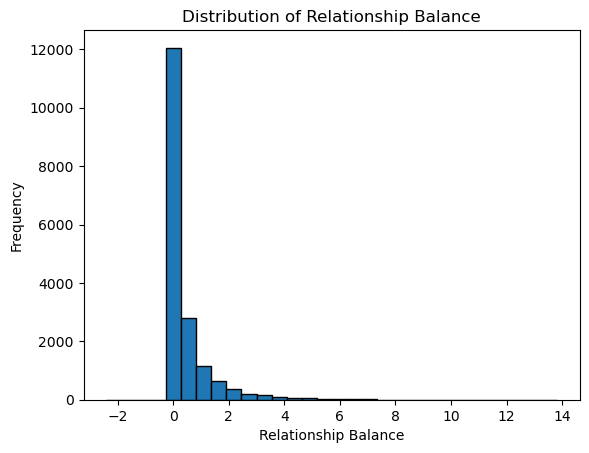

In [43]:
# plt.hist(df_pipeline3["fe_amt_ratio_to_balance"], bins=30, edgecolor='k')
plt.hist(np.log1p(df_pipeline3["fe_amt_ratio_to_balance"]), bins=30, edgecolor='k')
plt.title("Distribution of Relationship Balance")
plt.xlabel("Relationship Balance")
plt.ylabel("Frequency")
plt.show()

In [25]:
df_pipeline3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 85 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   masked_bank_num                              17765 non-null  int64  
 1   masked_account_type                          17765 non-null  int64  
 2   masked_product_code                          17765 non-null  int64  
 3   number_of_owners                             17765 non-null  int64  
 4   total_deposit_amount                         17765 non-null  float64
 5   item_amt                                     17765 non-null  float64
 6   relationship_balance                         17765 non-null  int64  
 7   rdis                                         17765 non-null  float64
 8   max_deposit_amount30d                        17765 non-null  float64
 9   total_deposit_item_count                     17765 non-null  int64  
 10

# 之前写的⬇️

In [26]:
def process_calgorial_features(df):

    '''
    one hot encoding:
    - masked_bank_num
    - masked_account_type
    - masked_product_code_grouped
    - relationship_balance_new_account
    - oao_flg
    - onus_ind
    - treasury_check_ind
    - heloc_ind
    '''

    # drop unused columns
    cols_to_drop = ['masked_dep_acct_num', 'masked_id', 'channel', 'drawee_avg', 'drawee_max', 'drawee_min', 'RDI_DT', 'RETURN_REASON', 'over_draft_amount']
    df.drop(columns=cols_to_drop, inplace=True)

    # process masked_product_code
    top_n = 8
    top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
    df['masked_product_code_grouped'] = df['masked_product_code'].apply(
        lambda x: f'prod_{x}' if x in top_product_codes else 'Other'
    )
    df.drop(columns='masked_product_code', inplace=True)

    # one_hot_features = ['masked_bank_num', 'masked_account_type', 'masked_product_code_grouped']
    # df = pd.get_dummies(df, columns=one_hot_features)
    
    df['oao_flg'] = (df['oao_flg'] == 'Y').astype(int)


    '''
    ordinal encoding
    - bucket_days_since_open
    - deposit_quarter
    - deposit_dayofweek
    '''

    # fill missing values with -1
    df['bucket_days_since_open'] = df['bucket_days_since_open'].fillna(-1)
    ordinal_mapping = {
    '0-1000': 0,
    '1000-2000': 1,
    '2000-5000': 2,
    '5000+': 3,
    -1: -1   
    }
    
    df['bucket_days_since_open'] = df['bucket_days_since_open'].map(ordinal_mapping)
    print(df['bucket_days_since_open'].unique())

    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
    df['deposit_quarter'] = df['deposit_dt'].dt.quarter.astype(str)  # convert to str for one-hot
    df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek.astype(str)  # convert to str for one-hot
    df.drop(columns='deposit_dt', inplace=True)

    cat_ftrs = ['onus_ind', 'treasury_check_ind', 'heloc_ind',
            'masked_bank_num', 'masked_account_type', 'masked_product_code_grouped', 'relationship_balance_new_account', 'oao_flg', 'deposit_dayofweek', 'deposit_quarter']

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='other')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


    return categorical_transformer, cat_ftrs


def process_continous_features(df):
    # total_deposit_amount
    df['total_deposit_amount'] = df['total_deposit_amount'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # item_amt
    df['item_amt'] = df['item_amt'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # relationship_balance
    df['relationship_balance_new_account'] = (df['relationship_balance'] == -99999999).astype(int)
    df['relationship_balance'] = df['relationship_balance'].replace(-99999999, np.nan)
    median_val = df['relationship_balance'].median()
    df['relationship_balance'] = df['relationship_balance'].fillna(median_val)
    min_val = df['relationship_balance'].min()
    shift = 1 - min_val if min_val <= 0 else 0
    df['relationship_balance'] = np.log1p(df['relationship_balance'] + shift)

    # rdis, max_deposit_amount30d, total_deposit_item_count
    # drawee_sum, drawee_cnt
    num_ftrs = ['drawee_sum', 'drawee_cnt']
    log_num_ftrs = ['rdis', 'max_deposit_amount30d', 'total_deposit_item_count']

    df['rdis'] = df['rdis'].fillna(0)
    df['drawee_sum'] = df['drawee_sum'].fillna(0)
    df['drawee_cnt'] = df['drawee_cnt'].fillna(0)

    numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

    log_numeric_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p, feature_names_out = 'one-to-one')),
        ('scaler', RobustScaler())])
    
    return log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs

'''
helper function for process_prevtran_features
'''
def prevtran_missing_imputation(df, flag="zero"):
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    if flag == "zero":
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        df[prevtran_cols] = imputer.fit_transform(df[prevtran_cols])
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'zero' is supported.")

'''
helper function for process_prevtran_features
'''
def prevtrandate_missing_imputation(df, flag="prevdate"):

    if flag == "prevdate":
        def impute_prevtrandate(row):
            # Find the last available value (starting from 10 to 1)
            for i in reversed(range(10)):
                val = row[prevtrandate_cols[i]]
                if not pd.isna(val):
                    return row.fillna(val)
            return row.fillna(0)

        prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
        df[prevtrandate_cols] = df[prevtrandate_cols].apply(impute_prevtrandate, axis=1)
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'prevdate' is supported.")

'''
Helper function for process_prevtran_features
'''
from statsmodels.tsa.stattools import acf

def compute_acf_lag1(row):
    x = row.values.astype(float)
    return pd.Series([acf(x, nlags=1, fft=False)[1]])

'''
deal with prevtran* and prevtrandate*
'''
def process_prevtran_features(df):

    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]  # keep prevtran1–6
    drop_prevtran_cols = [f'prevtran{i}' for i in range(7, 11)]

    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]  # keep prevtrandate1–3
    drop_prevtrandate_cols = [f'prevtrandate{i}' for i in range(4, 11)]

    # Mean, median, std, min, max, and sum across previous transactions, 
    # preserve absence of behavior in the statistics by computing before imputing
    df['prevtran_mean'] = df[prevtran_cols].mean(axis=1, skipna=True)
    df['prevtran_std'] = df[prevtran_cols].std(axis=1, skipna=True)
    df['prevtran_sum'] = df[prevtran_cols].sum(axis=1, skipna=True)
    df['prevtran_valid_count'] = df[prevtran_cols].notnull().sum(axis=1)

    # prevtrandate summary stats
    df['prevtrandate_mean'] = df[prevtrandate_cols].mean(axis=1, skipna=True)
    df['prevtrandate_std'] = df[prevtrandate_cols].std(axis=1, skipna=True)

    # add an isoutlier column to preserve extreme behavior as a signal
    threshold = df[prevtran_cols].stack().quantile(0.99)
    df['isoutlier_prevtran'] = (df[prevtran_cols].max(axis=1) > threshold).astype(int)

    # impute missing values
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    # if not check_prevtran_imputed:
    #     raise ValueError(f"Imputation incomplete: Some prevtran/prevtrandate values are still missing.")

    # take log of prevtran1–6, since data right-skewed
    df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)

    # prevtran_diff0, prevtran_ratio0
    df['prevtran_diff0'] = df['total_deposit_amount'] - df['prevtran1']
    df['prevtran_ratio0'] = df['total_deposit_amount'] / (df['prevtran1'] + 1e-3)
    
    # prevtran_diff1, prevtran_ratio1
    df['prevtran_diff1'] = df['prevtran1'] - df['prevtran2']
    df['prevtran_ratio1'] = df['prevtran1'] / (df['prevtran2'] + 1e-3)
    
    # timeseries features: acf
    df[['acf_lag1']] = df[keep_prevtran_cols].apply(compute_acf_lag1, axis=1)

    # rolling window features
    # TODO
    
    # drop columns
    columns_to_drop = (drop_prevtran_cols + drop_prevtrandate_cols)
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


def normalization(df):
    robust_scaler = RobustScaler()
    standard_scaler = StandardScaler()

    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]

    robust_scalar_features = ['total_deposit_amount', 'item_amt'] + keep_prevtran_cols + \
                        ['prevtran_mean', 'prevtran_std', 'prevtran_sum', 'prevtran_diff0', 'prevtran_ratio0'] + \
                        ['prevtran_diff1', 'prevtran_ratio1', 'acf_lag1']
    standard_scaler_features = keep_prevtrandate_cols + ['relationship_balance', 'drawee_sum', 'drawee_cnt',
   'rdis', 'max_deposit_amount30d', 'total_deposit_item_count'] + ['prevtrandate_mean', 'prevtrandate_std']
    
    return robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features


def feature_engineer(df):

    categorical_transformer, cat_ftrs = process_calgorial_features(df)
    log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs = process_continous_features(df)
    process_prevtran_features(df)
    robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features = normalization(df)
    
    preprocessor = ColumnTransformer(
        transformers=[
            # From categorical_transformer
            ('cat', categorical_transformer, cat_ftrs),

            # From continous_transformer (log and standard scaled)
            ('log_num', log_numeric_transformer, log_num_ftrs),
            ('num', numeric_transformer, num_ftrs),

            # From normalizer
            ('robust_scaler', robust_scaler, robust_scalar_features),
            ('standard_scaler', standard_scaler, standard_scaler_features)
        ],
        remainder='passthrough')
    X_transformed = preprocessor.fit_transform(df)
    feature_names = preprocessor.get_feature_names_out()
    df_final = pd.DataFrame(X_transformed, columns=feature_names, index=df.index)
    
    return X_transformed, df_final

## Check

In [27]:
df = load_data()
top_n = 8
top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
print(top_product_codes)

Index([1, 0, 2, 4, 5, 6, 7, 9], dtype='int64', name='masked_product_code')


In [28]:
df_final['remainder__bucket_days_since_open'].value_counts()

NameError: name 'df_final' is not defined

In [ ]:
df_final['remainder__number_of_owners'].value_counts()

remainder__number_of_owners
1.0    8713
2.0    6411
0.0    1972
3.0     557
4.0      97
5.0       8
6.0       3
8.0       2
7.0       2
Name: count, dtype: int64

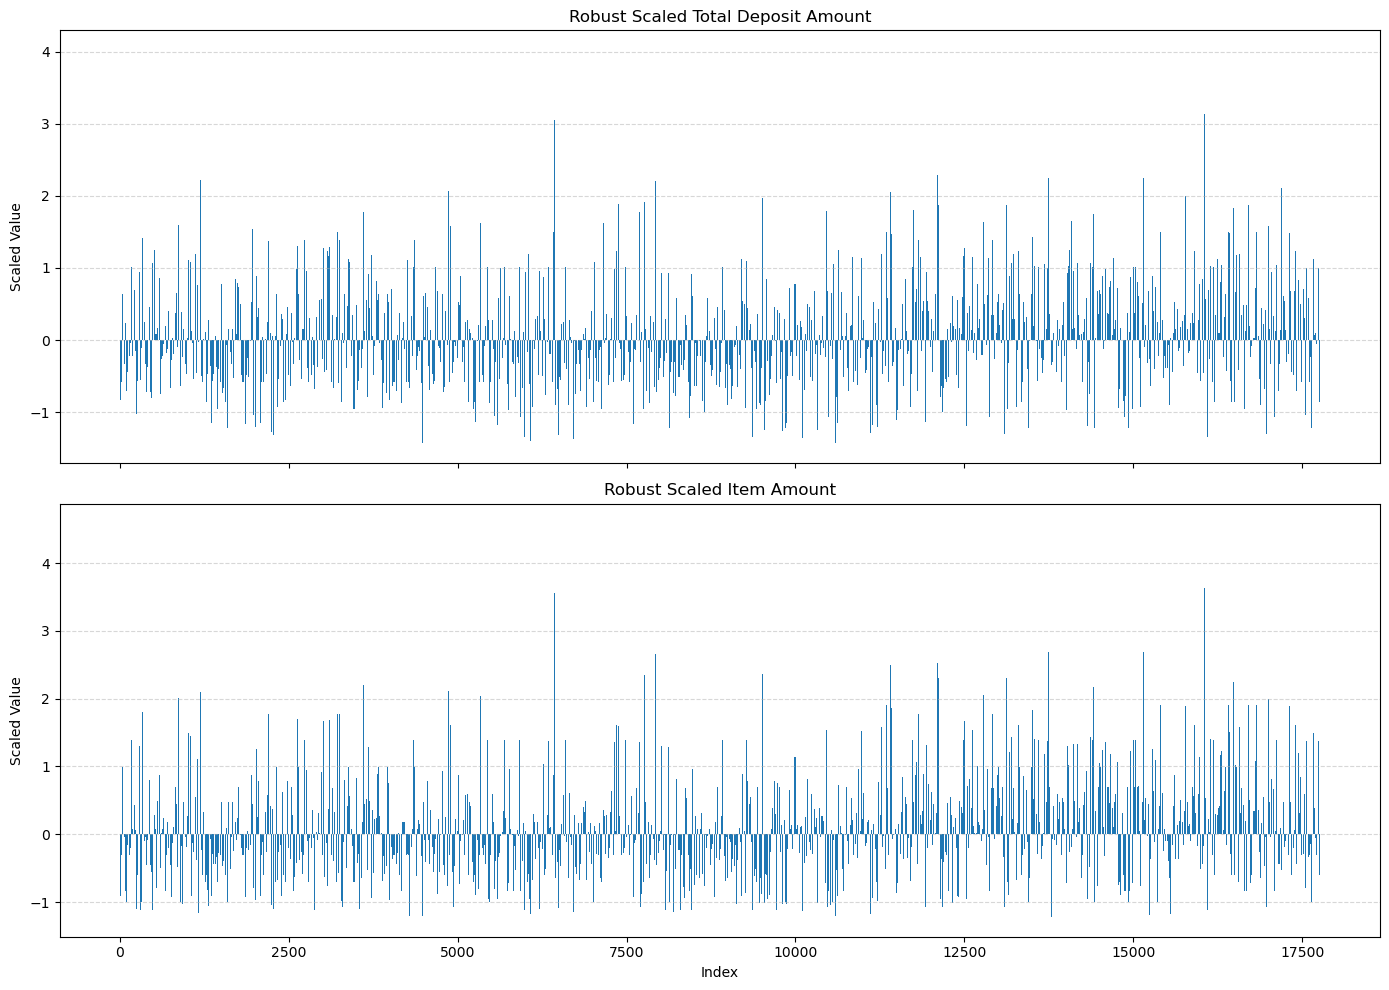

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# total_deposit_amount
axes[0].bar(df_final.index, df_final['robust_scaler__total_deposit_amount'])
axes[0].set_title('Robust Scaled Total Deposit Amount')
axes[0].set_ylabel('Scaled Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# item_amt
axes[1].bar(df_final.index, df_final['robust_scaler__item_amt'])
axes[1].set_title('Robust Scaled Item Amount')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Scaled Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [ ]:
df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek
print(df['deposit_dayofweek'].value_counts().sort_index())


deposit_dayofweek
0    4907
1    3367
2    2801
3    2692
4    3998
Name: count, dtype: int64


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   cat__onus_ind_F                            17765 non-null  float64
 1   cat__onus_ind_T                            17765 non-null  float64
 2   cat__treasury_check_ind_N                  17765 non-null  float64
 3   cat__treasury_check_ind_Y                  17765 non-null  float64
 4   cat__heloc_ind_N                           17765 non-null  float64
 5   cat__heloc_ind_Y                           17765 non-null  float64
 6   cat__masked_bank_num_0                     17765 non-null  float64
 7   cat__masked_bank_num_1                     17765 non-null  float64
 8   cat__masked_bank_num_2                     17765 non-null  float64
 9   cat__masked_bank_num_3                     17765 non-null  float64
 10  cat__masked_bank_num_4